<a href="https://colab.research.google.com/github/atejap05/pos_data_science_furg/blob/main/disciplinas/Machine_Learning_II/Furg_ECD_Machine_Learning_II_Semana_05_Tarefa_Aprendizado_semi_supervisionado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning II - Tarefa: Aprendizado semi-supervisionado
### Prof. Marcelo Malheiros

Parte do código adaptada de Aurélien Geron (licença Apache-2.0)

---

Esta tarefa é para você **observar** e **analisar** este processo de Machine Learning.

Adicionalmente, sugere-se que você também experimente com os dados e com os algoritmos, fazendo algumas das modificações indicadas em várias partes deste _notebook_.

Note que não é preciso escrever mais código, apenas modificar o código já fornecido.

Um questionário _online_ dentro da disciplina no AVA será disponibilizado para coletar sua análise. Este questionário será também uma das tarefas avaliativas desta disciplina.

# Problema

O problema aqui descrito é uma **tarefa de classificação semi-supervisionada**. Com base na identificação de apenas alguns dígitos manuscritos, experimentaremos estratégias para **rotular automaticamente** todo o restante de um conjunto de dados.

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_:

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


# Conjunto de dados

Vamos trabalhar com o _dataset_ embutido na biblioteca Scikit-Learn chamado `digits`, que contém 1797 imagens em tons de cinza representando os dígitos manuscritos de 0 a 9.

Cada instância corresponde a uma matriz de 8 × 8 pixels, ou seja, contém 64 atributos. Adicionalmente, também usaremos os rótulos fornecidos por este _dataset_ como teste da qualidade do nosso processo de rotulagem.

In [1]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Vamos dividir os dados em 75% como conjunto de treinamento e 25% como conjunto de teste.

Para os dados de treino, iremos trabalhar apenas com os atributos. Os rótulos de treino serão usados uma única vez, para definir nossa acurácia de referência.

Os dados de teste (atributos e rótulos) serão usados para medir a acurácia dos classificadores construídos.

In [112]:
from sklearn.model_selection import train_test_split

# separação dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X_digits, y_digits, random_state=42, train_size=0.75)

In [113]:
len(X_treino)

1347

In [114]:
print('atributos de treino', X_treino.shape)
print('rótulos de treino  ', y_treino.shape)
print('atributos de teste ', X_teste.shape)
print('rótulos de teste   ', y_teste.shape)

atributos de treino (1347, 64)
rótulos de treino   (1347,)
atributos de teste  (450, 64)
rótulos de teste    (450,)


# Acurácia de referência

Usaremos os dados completos de treino e teste para medir a **acurácia** de referência para este _dataset_, usando para isso uma tarefa tradicional de classificação supervisionada com o algoritmo `LogisticRegression`. Lembrando, apesar do nome este algoritmo pode funcionar como um **classificador multiclasse**.

Outro classificador poderia ser usado. Por exemplo, o `RandomForestClassifier`, que teria uma acurácia semelhante à obtida a seguir.

In [115]:
from sklearn.linear_model import LogisticRegression

# criação do classificador
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)

# treinamento com os dados completos de treino
log_reg.fit(X_treino, y_treino)

# acurácia média com base nos dados de teste
log_reg.score(X_teste, y_teste)

0.9688888888888889

Esta é a nossa linha de base: 96,9% de acurácia.

Vamos ver se podemos chegar próximo desse percentual usando diversas estratégias de classificação semi-supervisionada...

# Rotulagem manual de algumas instâncias

A ideia da classificação semi-supervisionada é dispor de apenas algumas poucas instâncias rotuladas, o que tipicamente é feito manualmente.

De um total de 1347 instâncias de treino, vamos primeiro experimentar treinar o mesmo tipo de classificador com apenas 50 instâncias quaisquer. Por simplicidade, vamos selecionar os 50 primeiros dígitos de treino e definir explicitamente seus rótulos.

In [116]:
n_primeiras = 50

X_treino_primeiras = X_treino[:n_primeiras]

In [117]:
# função auxiliar para mostrar grupos de 10 dígitos
def exibe_dígitos(X):
    plt.figure(figsize=(10, 4))
    for index, X_digit in enumerate(X):
        plt.subplot(X.shape[0] // 10, 10, index + 1)
        plt.imshow(X_digit.reshape(8, 8), cmap='binary', interpolation='none')
        plt.axis('off')
    plt.show()

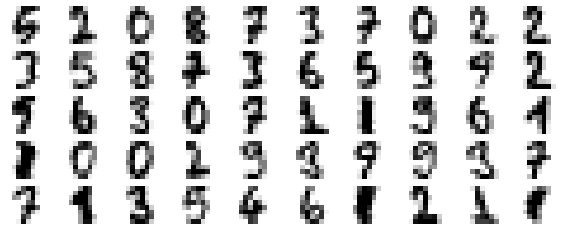

In [118]:
# vamos exibir os primeiros 50 dígitos
exibe_dígitos(X_treino_primeiras)

In [119]:
# Aqui definimos manualmente os rótulos de cada uma destas instâncias
y_treino_primeiras = np.array([5, 2, 0, 8, 7, 3, 7, 0, 2, 2, \
                               3, 5, 8, 7, 3, 6, 5, 9, 9, 2, \
                               5, 6, 3, 0, 7, 1, 1, 9, 6, 1, \
                               1, 0, 0, 2, 9, 3, 9, 9, 3, 7, \
                               7, 1, 3, 5, 4, 6, 1, 2, 1, 1])

In [120]:
# vamos criar um novo classificador, apenas para estas 50 instâncias
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_treino_primeiras, y_treino_primeiras)
log_reg.score(X_teste, y_teste)

0.8333333333333334

A acurácia ficou bem abaixo do valor de referência de 96,9%, mas isso já era esperado. Primeiro porque estamos treinando apenas com um número bem pequeno de instâncias (50). Segundo, porque estas instâncias provavelmente não foram as mais adequadas de se rotular.

Veremos em seguida como aprimorar este processo semi-supervisionado.

# Usando clusterização no Aprendizado Semi-supervisionado

Quando temos muitas instâncias não rotuladas e poucas instâncias rotuladas, podemos usar a clusterização como forma de ganhar mais conhecimento sobre os dados. E por conseguinte, rotular instâncias mais significativas.

## Clusterização

Primeiro, vamos agrupar o conjunto de treinamento em 50 _clusters_, usando o algoritmo `KMeans`. Esse número de _clusters_ é arbitrário, mas poderíamos usar uma análise de curva de inércia ou de coeficiente de silhueta para procurar um número mais adequado a estes dados.

É importante notar que mesmo que saibamos que as imagens dos dígitos representam apenas 10 classes, a escolha do número de _clusters_ não precisa estar atrelado a este valor.

1622017.123979213


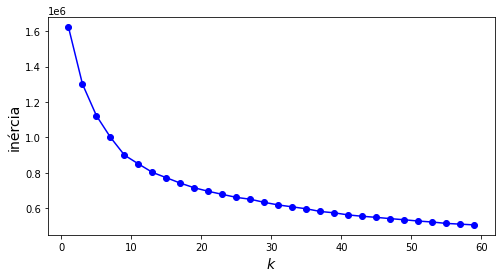

In [123]:
# gera diversos modelos à medida em que k varia
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_treino) for k in range(1, 60, 2)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias[0])
# gráfico
plt.figure(figsize=(8, 4))
plt.plot(range(1, 60, 2), inertias, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('inércia', fontsize=14)
""" plt.annotate('cotovelo', xy=(4, inertias[3]), xytext=(0.55, 0.55), textcoords='figure fraction',
             fontsize=16, arrowprops=dict(facecolor='black', shrink=0.1)) """
#plt.axis([10, 80.5, 1, 100000])
#plt.savefig('inertia-k', dpi=100)
plt.show()

In [154]:
n_clusters = 60

In [155]:
from sklearn.cluster import KMeans

# criação do clusterizador
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# treinamento com os dados completos
kmeans.fit(X_treino)

KMeans(n_clusters=60, random_state=42)

Após o treinamento, o modelo identificou 50 _clusters_. Cada um deles tem um **centróide** ao qual são associadas as instâncias mais próximas.

As informações que nos interessam agora são as distâncias de cada instância a cada centróide, dadas pela função `.transform()` e também em que _cluster_ está cada instância, informado pela função `.predict()`.

In [156]:
# distâncias para cada um dos centróides
X_treino_todas_distâncias = kmeans.transform(X_treino)

# associação de instâncias ao seu cluster
X_treino_clusters = kmeans.predict(X_treino)

Como apenas nos interessa a distância de uma instância ao seu centróide (e não a todos), podemos consolidar os dados anteriores em uma só matriz: cada linha é uma instância e a única coluna corresponde à distância ao centróide associado.

In [157]:
X_treino_distâncias = X_treino_todas_distâncias[np.arange(len(X_treino)), X_treino_clusters]
X_treino_distâncias.shape

(1347,)

## Seleção das instâncias mais representativas

Agora, para cada conjunto de instâncias associado a um _cluster_, vamos selecionar a instância com menor distância do centróide.

Isso significa que estaremos identificando instâncias bem centrais em cada _cluster_, e portanto representativas dos seus grupos.

**Experimentação:** Teste selecionar duas instâncias representativas para cada _cluster_, alterando a variável `n_representativas` abaixo. É preciso também ajustar os rótulos para as 100 imagens representativas que serão exibidas depois.

In [158]:
n_representativas = 2

In [159]:
# função auxiliar
def índices_dos_menores(a, n):
    if np.ma.isMaskedArray(a):
        n = min(n, a.count())
    idxs = np.argsort(a)
    return idxs[:n]

In [160]:
índices = []

# para cada cluster
for c in range(n_clusters):
    # cria um 'masked array' mantendo visíveis apenas as instâncias do cluster 'c'
    ma = np.ma.masked_where(X_treino_clusters != c, X_treino_distâncias)

    # obtém o índice da instância com menor distância ao centro deste cluster
    índices += list(índices_dos_menores(ma, n_representativas))

In [161]:
print(índices)

[665, 826, 89, 1151, 588, 991, 660, 398, 1146, 220, 119, 81, 1246, 712, 654, 409, 410, 841, 987, 1148, 151, 885, 1186, 976, 1290, 1104, 1102, 733, 891, 934, 23, 1311, 559, 110, 525, 837, 645, 602, 535, 730, 1057, 1100, 689, 157, 1071, 1150, 791, 1265, 1308, 661, 944, 569, 1108, 634, 1312, 783, 460, 617, 1149, 529, 772, 749, 433, 576, 159, 80, 702, 99, 563, 36, 396, 953, 705, 139, 26, 766, 697, 408, 817, 1321, 1267, 237, 1092, 1070, 515, 1337, 1022, 615, 649, 861, 256, 757, 249, 481, 1343, 776, 753, 519, 114, 59, 1194, 1158, 337, 748, 1038, 804, 512, 489, 795, 1315, 1211, 565, 745, 674, 1163, 238, 683, 577, 1156, 1206]


Agora vamos usar estes 50 índices para copiar os atributos para um novo _dataset_ de treino para o classificador.

In [162]:
# novo dataset
X_treino_representativas = X_treino[índices]

Então vamos plotar essas instâncias representativas e rotulá-las manualmente a seguir.

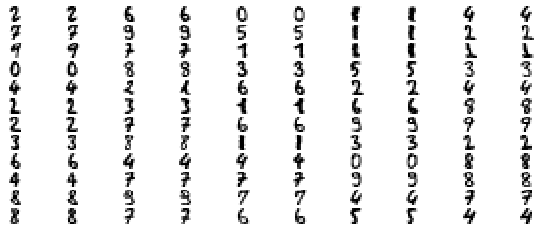

In [163]:
exibe_dígitos(X_treino_representativas)

In [164]:
y_treino_representativas = [2, 2, 6, 6, 0, 0, 1, 1, 4, 4,
                            7, 7, 9, 9, 5, 5, 1, 1, 2, 2,
                            9, 9, 7, 7, 1, 1, 1, 1, 1, 1,
                            0, 0, 8, 8, 3, 3, 5, 5, 3, 3,
                            4, 4, 2, 2, 6, 6, 2, 2, 4, 4,
                            2, 2, 3, 3, 1, 1, 6, 6, 8, 8,
                            2, 2, 7, 7, 6, 6, 9, 9, 9, 9,
                            3, 3, 8, 8, 1, 1, 3, 3, 2, 2,
                            6, 6, 4, 4, 4, 4, 0, 0, 8, 8,
                            4, 4, 7, 7, 7, 7, 9, 9, 8, 8,
                            8, 8, 9, 9, 7, 7, 4, 4, 7, 7,
                            8, 8, 7, 7, 6, 6, 5, 5, 4, 4]

## Treinamento de um novo classificador

Temos no momento um conjunto de dados com apenas 50 instâncias rotuladas, mas em vez de serem instâncias aleatórias, cada uma delas é uma instância representativa de seu _cluster_.

Vamos treinar um novo classificador para verificar se o desempenho ficou melhor.

In [165]:
# vamos criar um novo classificador, para as 50 instâncias representativas
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_treino_representativas, y_treino_representativas)
log_reg.score(X_teste, y_teste)

0.9155555555555556

O aumento da acurácia é definitivamente melhor, pulando de 83,4% para 92,2%. Note que estamos mais próximos da acurária de referência de 96,9%, mesmo que usando apenas 50 instâncias.

Como costuma ser caro e trabalhoso rotular as instâncias, especialmente quando precisa ser feito manualmente por especialistas, uma boa ideia é fazer com que estes rotulem instâncias representativas em vez de apenas instâncias aleatórias.

## Propagação de rótulos para todo o _cluster_

Uma estratégia adicional e que pode ser interessante é propagar os rótulos das instâncias representativas (definidas anteriormente) para todas as outras instâncias do mesmo cluster. Assim poderíamos usar o conjunto de treino completo, e não apenas as 50 instâncias representativas.

In [166]:
# matriz-coluna para receber os rótulos propagados
y_treino_propagado = np.empty(len(X_treino), dtype=int)

# para cada cluster
for c in range(n_clusters):
    # defina os rótulos das instâncias deste cluster com base no rótulo da sua instância representativa
    y_treino_propagado[X_treino_clusters == c] = y_treino_representativas[c * n_representativas]

In [167]:
# vamos criar um novo classificador, para todas as instâncias com rótulos propagados
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_treino, y_treino_propagado)
log_reg.score(X_teste, y_teste)

0.9288888888888889

De fato, percebe-se um pequeno ganho. E com pouco esforço.

## Propagação parcial de rótulos

Uma estratégia que seria teoricamente melhor é propagar os rótulos apenas para um percentual das instâncias mais próximas a cada centróide.

A lógica é que as instâncias mais distantes podem ser _outliers), e neste caso poderiam ser deixadas de fora. Assim temos um conjunto de treino com bem mais que 50 instâncias, mas sem usar instâncias potencialmente problemáticas.

Vamos então definir a propagação para as 75% das instâncias mais próximas, para cada _cluster_.

**Experimentação:** Teste modificar o percentual de propagação para valores mais baixos, como por exemplo 15% ou 55%. Note que se definirmos 100% teremos exatamente a situação anterior de propagação para todas as instâncias.

In [168]:
# critério de uso
percentual = 85

In [169]:
# vetor que irá conter apenas as distâncias dentro do percentual
distâncias = X_treino_distâncias.copy()

# para cada cluster
for c in range(n_clusters):
    # máscara de booleanos de instâncias no cluster 'c'
    no_cluster = (X_treino_clusters == c)
    
    # apenas distâncias das instâncias neste cluster
    cluster_dist = distâncias[no_cluster]
    
    # distância de corte
    corte = np.percentile(cluster_dist, percentual)
    
    # máscara de corte (para mais distantes)
    acima_do_corte = (distâncias > corte)
    
    # remove distâncias das instâncias que não interessam
    distâncias[no_cluster & acima_do_corte] = -1

In [170]:
parcialmente_propagado = (distâncias != -1)
X_treino_parcial = X_treino[parcialmente_propagado]
y_treino_parcial = y_treino_propagado[parcialmente_propagado]

In [171]:
print('novo treino atributos', X_treino_parcial.shape)
print('novo treino rótulos  ', y_treino_parcial.shape)

novo treino atributos (1124, 64)
novo treino rótulos   (1124,)


In [172]:
# vamos criar um novo classificador, apenas para as instâncias com rótulos propagados
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000, random_state=42)
log_reg.fit(X_treino_parcial, y_treino_parcial)
log_reg.score(X_teste, y_teste)

0.94

O resultado em geral fica um pouco melhor ao se usar propagação parcial, mas depende do percentual dos valores mantidos.

Com apenas 50 instâncias rotuladas (apenas 5 exemplos por classe em média) e propagando os demais rótulos, obtivemos  um desempenho que se aproxima do desempenho da regressão logística no _dataset_ totalmente rotulado (que foi de 96,9%).

A explicação para o bom desempenho é que os rótulos propagados são realmente muito bons. Podemos comparar diretamente a acurácia deles em relação aos rótulos do conjunto de dados original:

In [173]:
# ATENÇÃO: esta é acurácia apenas dos rótulos propagados (e não do classificador treinado)
np.mean(y_treino_parcial == y_treino[parcialmente_propagado])

0.9724199288256228

**Experimentação avançada:** Teste valores menores (por exemplo, 10) e maiores (por exemplo, 80) para o número de _clusters_ definido por `n_clusters` (na seção **Clusterização**). Então execute novamente os demais trechos do notebook, notando o efeito na acurácia.

O número de _clusters_ precisa ser múltiplo de 10 para a visualização dos dígitos funcione adequadamente. Note que as instâncias manualmente rotuladas (na seção **Seleção das instâncias mais representativas**) também terão que ser ajustadas de acordo.